In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [4]:
# 데이터 로드
train_df = pd.read_csv('train.csv')


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
missing_values = train_df.isnull().sum()

print("결측치 데이터 : ", missing_values[missing_values > 0])

결측치 데이터 :  Age         177
Cabin       687
Embarked      2
dtype: int64


In [10]:
numeric_cols_to_check = ['Age', 'Fare', 'SibSp', 'Parch']

print("수치형 데이터에 대한 데이터 범위 확인 :", train_df[numeric_cols_to_check].describe())

수치형 데이터에 대한 데이터 범위 확인 :               Age        Fare       SibSp       Parch
count  714.000000  891.000000  891.000000  891.000000
mean    29.699118   32.204208    0.523008    0.381594
std     14.526497   49.693429    1.102743    0.806057
min      0.420000    0.000000    0.000000    0.000000
25%     20.125000    7.910400    0.000000    0.000000
50%     28.000000   14.454200    0.000000    0.000000
75%     38.000000   31.000000    1.000000    0.000000
max     80.000000  512.329200    8.000000    6.000000


Text(0.5, 1.0, 'Age')

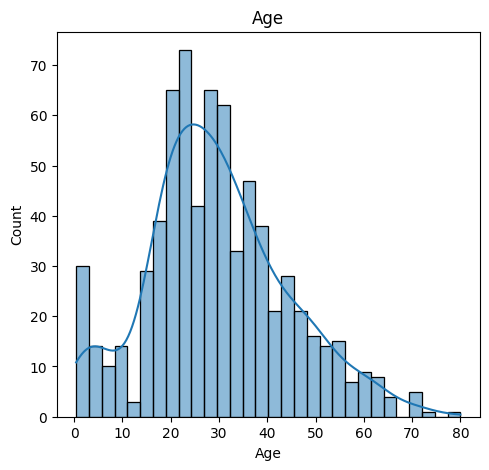

In [11]:
# age 값의 분포 확인

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_df['Age'], kde=True, bins=30)
plt.title('Age')

Text(0.5, 1.0, 'Fare Distribution')

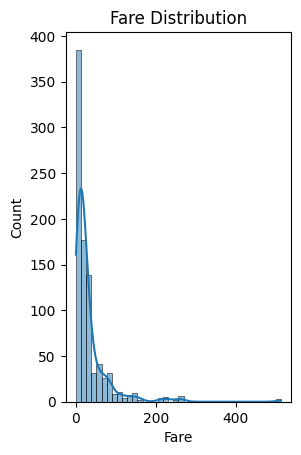

In [12]:
# Fare의 분포확인

plt.subplot(1, 2, 2)
sns.histplot(train_df['Fare'], kde=True, bins=40)
plt.title('Fare Distribution')

In [14]:
# 범주형 데이터의 값별 개수 확인

categorical_cols_to_check = ['Sex', 'Pclass', 'Embarked']
for col in categorical_cols_to_check:
  print(f"\n[{col}] Value Counts (including NaN):")

  print(train_df[col].value_counts(dropna=False))


[Sex] Value Counts (including NaN):
Sex
male      577
female    314
Name: count, dtype: int64

[Pclass] Value Counts (including NaN):
Pclass
3    491
1    216
2    184
Name: count, dtype: int64

[Embarked] Value Counts (including NaN):
Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64


In [19]:
print(f"PassengerId 고유값 개수: {train_df['PassengerId'].nunique()} / {len(train_df)}")
print(f"Name 고유값 개수: {train_df['Name'].nunique()} / {len(train_df)}")
print(f"Ticket 고유값 개수: {train_df['Ticket'].nunique()} / {len(train_df)}")

PassengerId 고유값 개수: 891 / 891
Name 고유값 개수: 891 / 891
Ticket 고유값 개수: 681 / 891


In [20]:
# 제외 항목 제거
X = train_df.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
y = train_df['Survived']

In [21]:
# 수치형 데이터 스케일링 처리
numeric_features = ['Fare', 'SibSp', 'Parch']
numeric_features_with_missing = ['Age']

In [23]:
# OHE 대상
categorical_features = ['Sex', 'Pclass']
categorical_features_with_missing = ['Embarked']

In [24]:
#  - StandardScaler: 평균 0, 분산 1로 스케일링
numeric_transformer = Pipeline(steps=[
  ('scaler', StandardScaler())
])

In [25]:
#  - SimpleImputer: 결측치를 '중앙값(median)'으로 대체
#  - StandardScaler: 스케일링
numeric_impute_transformer = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='median')),
  ('scaler', StandardScaler())
])

In [26]:
#  - OneHotEncoder: 범주를 0/1의 더미 변수로 변환 (handle_unknown='ignore'는 테스트 데이터에 새로운 값이 나와도 에러 방지)
categorical_transformer = Pipeline(steps=[
  ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [27]:
#  - SimpleImputer: 결측치를 '최빈값(most_frequent)'으로 대체
#  - OneHotEncoder: 원-핫 인코딩
categorical_impute_transformer = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='most_frequent')),
  ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [28]:

# 파이프라인 통합

preprocessor = ColumnTransformer(
  transformers=[
    # (이름, 파이프라인, 적용할 컬럼 리스트)
    ('num', numeric_transformer, numeric_features),
    ('num_impute', numeric_impute_transformer, numeric_features_with_missing),
    ('cat', categorical_transformer, categorical_features),
    ('cat_impute', categorical_impute_transformer, categorical_features_with_missing)
  ],
  remainder='passthrough' # 위에서 정의하지 않은 컬럼은 통과시킴 (현재는 없음)
)

In [29]:
# 1. 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=79)

In [30]:
# fit_transform은 학습(train) 데이터에만 사용 (평균, 중앙값 등을 학습)
X_train_preprocessed = preprocessor.fit_transform(X_train)

In [31]:
# transform은 테스트(test) 데이터에 사용 (학습된 값으로 변환만 적용)
X_test_preprocessed = preprocessor.transform(X_test)

In [32]:

# 변환 결과 확인
print("원본 학습 데이터 shape:", X_train.shape)

# (Age 1개 + Fare/SibSp/Parch 3개 + Sex 2개 + Pclass 3개 + Embarked 3개 = 총 12개 피처)
print("전처리 후 학습 데이터 shape:", X_train_preprocessed.shape)

원본 학습 데이터 shape: (712, 7)
전처리 후 학습 데이터 shape: (712, 12)
